In [ ]:
## in datahub, need to install packages. 
## Need to let support know that the package is needed (if not already on system - try first), 
## they make is available in the system and then you can install with the following command 
## at the top of your notebook

!pip install obspy

# TDMT Wrapper

Danielle Lindsay - 14 Oct 2020

For this notebook to run fully the Time-Domain Moment Tensor INVerse Code (tdmt_invc_iso) needs to be installed locally. 
http://seismo.berkeley.edu/~dreger/mtindex.html

You need to provide a 1D velocity model (example included in scripts directory)

For earthquake of the week I have provided the output files required to run and show what you would get if you did have the program installed locally. 

This notebook steps through the process of:
1. event selection
2. station selection
3. data prepation
4. tdmt prepation
5. calls tdmt commands to generate moment tensors
6. runs depth sensitivity tests 



### Load all libraries and set key parameters

In [14]:
#import all required packages
from obspy.clients.fdsn import Client
from obspy.clients.fdsn import Client as FDSN_Client
from obspy.clients.iris import Client as IRIS_Client 
from obspy.imaging.mopad_wrapper import beachball
from obspy import UTCDateTime
from obspy import read
from obspy import read_inventory
from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil

#processing directory
basepath = '/home/jovyan/EPS256-FA20/Wk06_tdmt_wrapper'
script_dir = '/home/jovyan/EPS256-FA20/Wk06_tdmt_wrapper/scripts'

#basepath = '/home/danielle/Wk06_tdmt_wrapper'
#script_dir = '/home/danielle/Wk06_tdmt_wrapper/scripts'

### Set Variables for event search

In [3]:
### Specify which catalogue to use 
# Data older than 7days in New Zeland
client = Client("GEONET")
# Data less than 7 days in New Zealand
#client = FDSN_Client("http://service-nrt.geonet.org.nz")

#Minimum magnitude for catelogue search
mnmag=4.5

# lat/lon for search origin
lat=-44.172503
lon=168.351580

#Search radius for earthquake location degrees
rad=2

#search time window
t1 = UTCDateTime("2020-01-01T00:00:00.00")
t2 = UTCDateTime("2020-10-13T00:00:00.00")

### Make catelogue of events

In [ ]:
# make catelogue
cat = client.get_events(starttime=t1, endtime=t2, minmagnitude=mnmag,
                    latitude=lat, longitude=lon, minradius=0, maxradius=rad)
#plot catelogue
cat.plot(projection="local",resolution="h")

#print catelogue
cat

### Narrow catelogue to just event of interest

In [ ]:
t = UTCDateTime("2020-06-24T22:20:01.695640") #**** Manually copy time from above. Definitely better way to do this... 

# make catelogue
cat = client.get_events(starttime=t-60, endtime=t+60, minmagnitude=mnmag,
                    latitude=lat, longitude=lon, minradius=0, maxradius=rad)
#plot catelogue
cat.plot(projection="local",resolution="h")

#print catelogue
cat

#Set event variables
origin = cat[0].preferred_origin() or cat[0].origins[0]
event_time = origin.time
event_lat = origin.latitude
event_lon = origin.longitude
event_depth = origin.depth
event_depth_km = event_depth/1000
magnitude = cat[0].preferred_magnitude() or cat[0].magnitudes[0]
mag = magnitude.mag

### Find stations 

In [ ]:
#Search radius for station location degrees
mnrad=0.7
mxrad=2

# Get station information at the response level:
inv = client.get_stations(network=None, station=None, location=None, channel="HH*",
                    starttime=t-1*60,endtime=t+5*60,level="response",
                    latitude=origin.latitude, longitude=origin.longitude, minradius=mnrad, maxradius=mxrad)

# plot inventory
inv.plot(projection="local", label=True, size=50, resolution="h")  

# set network
net = inv[0]

net

### Create directory structure for the event

In [7]:
## Set Velocity model to be used. 
vel_mod = "model_NZ_south.d"       #***** Change depending on region
vel_mod_path = ("%s/%s" % (script_dir, vel_mod))
mod_short = "NZS"

#Get working directories
def dirStructure(event):
        origin = event.preferred_origin() or event.origins[0]
        event_time = origin.time
        magnitude = event.preferred_magnitude() or event.magnitudes[0]
        mag = magnitude.mag
        event_name=("%s_M%s" % (event_time.strftime('%Y-%m-%dT%H-%M-%S'), round(mag,1)))
        event_dir = os.path.join(basepath, event_name)
        return event_dir 

for event in cat:
    event_dir = dirStructure(event)
    GFS_dir = os.path.join(event_dir, "GFS")
    GFS_scripts = os.path.join(script_dir, "GFS")
    data_dir = os.path.join(event_dir, "data")
    
    if not os.path.exists(event_dir):
        os.mkdir(event_dir)
        os.mkdir(data_dir)
        shutil.copytree(GFS_scripts, os.path.join(event_dir, 'GFS')) 
        shutil.copy(vel_mod_path, os.path.join(event_dir, 'GFS')) 
        print("Directory " , event_dir ,  " Created ")     
    else:    
        print("Directory " , event_dir ,  " already exists")

Directory  /home/danielle/Wk06_tdmt_wrapper/2020-06-24T22-20-01_M5.9  already exists


### Define functions to prepare data for tdmt

In [8]:
#Function to check that station has data available, if yes gets the data and checks that the traces are the same length and splices is required. 
def getWaveform(sta_code, event_time):
    print("Working on station %s"%(sta_code))
    try:
        #Check to see if there is data for the station, if yes do the following
        st = client.get_waveforms("NZ", sta_code ,"*", "HH*", event_time-60*1.5, event_time+60*5.5,attach_response=True)
        tr = st[0]
        
        #Check traces are all the same length - set equal start and end times
        starttimes = [tr.stats.starttime for tr in st]
        endtimes = [tr.stats.endtime for tr in st]
        stime = max(starttimes)
        etime = min(endtimes)
        st = st.slice(starttime=stime, endtime=etime)
    
    except:
        #If not data then print the following
        print('No data available for %s'%(sta_code))
        pass
        
    return st

#Function to get station information and calculate distance and azimuth between event and station
def getStaDistAz(sta, event_time):
    #Get station and event info
    origin = event.preferred_origin() or event.origins[0]
    event_lat = origin.latitude
    event_lon = origin.longitude
    event_depth = origin.depth
    event_depth_km = event_depth/1000
    sta_lat = sta.latitude
    sta_lon = sta.longitude

    # Calculate dist, az, backaz
    result = IRIS_Client().distaz(stalat=sta_lat, stalon=sta_lon, evtlat=event_lat ,evtlon=event_lon)
    distance = result['distancemeters']
    dist_km = distance/1000
    back_az = result['backazimuth']
    az = result['azimuth']
    return sta_lat, sta_lon, dist_km, back_az, az, origin, event_lat, event_lon, event_depth_km

# Function get available data, corrections for instrument response, removes mean, taper, filters, rotates to gcp and run sac2helm to produce sta_code.data files in GFS directory
def prepFilesForTdmt(event, inv):
    
    #Set up working directory
    event_dir = dirStructure(event)
    data_dir = os.path.join(event_dir, "data")
    GFS_dir = os.path.join(event_dir, "GFS")
    
    #Event info
    origin = event.preferred_origin() or event.origins[0]
    event_time = origin.time
    date=event_time.strftime('%Y-%m-%dT%H-%M-%S')
    
    #Set up files for tdmt inversion
    file1 = open('%s/stations_cat_%s.txt' % (GFS_dir,date), 'w')
    file2 = open('%s/dfile' % (GFS_dir), 'w')
    file3 = open('%s/mt_in_part1.txt' % (GFS_dir), 'w')
    file4 = open('%s/mt_in_part2.txt' % (GFS_dir), 'w')
    file5 = open('%s/distance.txt' % (GFS_dir), 'w')
    
    print("Working on event %s" % event_time)
    
    #Loop through all stations in inventory
    net = inv[0]
    for i, sta in enumerate(net):
        #Get station code
        sta_code = sta.code
        
        #Get waveform data
        st = getWaveform(sta_code, event_time)
        st.plot(starttime=event_time, endtime=event_time+120, outfile="%s/%s_raw_vel.png" % (data_dir, sta_code))
        print("Received waveforms for %s" % sta_code)
        
        #remove intrument response with pre fileter and remove zero mean 
        st.remove_response(output='DISP', pre_filt=(pf_min, pf_c1, pf_c2, pf_max), zero_mean=True, plot=False)
        print("Removed instrument response. Applied frequency prefilter %s, %s, %s, %s" % (pf_min, pf_c1, pf_c2, pf_max))

        #Get station and event location info
        sta_info = getStaDistAz(sta, event_time)
        print("Station %s, distance = %s, back az = %s, az = %s" % (sta_code, sta_info[2], sta_info[3], sta_info[4]))
        
        # Rotate to transverse and radial components
        st.rotate(method='NE->RT', back_azimuth=sta_info[3] )
        print("Data rotated to great circle path")

        # Detrend, taper and bandpass filter --- bp co 0.02 0.05 p 2           
        st.detrend("linear")
        st.taper(max_percentage=0.05, type="hann")
        st.filter('bandpass', freqmin=freq_min, freqmax=freq_max, corners=corner, zerophase=True)
        st.plot(outfile="%s/%s_rot_bp%s-%s_disp.png" % (data_dir, sta_code, freq_min, freq_max))
        print("Data detrended, tapered, bandpass filtered")

        #Resample to 1 Hz --- interpolate delta 1.0
        st.resample(1.0)
        stime = event_time-60*1 
        etime = event_time+60*5
        st = st.slice(starttime=stime, endtime=etime)
        print(st)
        print("Data Resampled to 1.0 Hz")
        
        #Write useful info, dfile and mt_inv files for tdmt inversions
        #lon lat sta
        file1.write("%s, %s, %s, %s, %s, %s \n" % (sta_info[1], sta_info[0], sta_code, sta_info[2], sta_info[3], sta_info[4]))
        file2.write("%s    1.0    512    0.0    0.0    \n" %(round(sta_info[2], 1)))
        file3.write("%s.data     %s     %s    0     120     \n" % (sta_code, round(sta_info[2], 1), round(sta_info[4], 1)))
        file4.write("%s_%sd%s    0    120     \n" % (mod_short, round(sta_info[2], 1), round(sta_info[8])))
        file5.write("%s " % (round(sta_info[2], 1)))          

        #Write out traves as SAC files
        for tr in st:
            # Mul 100 to get displacement in cm 
            tr.data=tr.data*100
            tr.write("%s/%s.SAC" % (data_dir,tr.id), format="SAC")

        #Write to temp files for sac2helm 
        st[0].write('%s/tmp1'% data_dir, format='SAC') 
        st[1].write('%s/tmp2'% data_dir, format='SAC') 
        st[2].write('%s/tmp3'% data_dir, format='SAC')

        print("Running sac2helm in data directory %s <----- THIS IS COMMENTED OUT FOR EQW" % data_dir)
        #Make date files for tdmt inversion
        os.chdir(data_dir)
        #!sac2helm out={GFS_dir}/{sta_code}.data ###<----- THIS IS COMMENTED OUT FOR EQW
        os.chdir(script_dir)
            
    file1.close()
    file2.close()
    file3.close()
    file4.close()
    file5.close()
    
    return;

## Get data and correct instrument response

NB: This calls on "sac2helm" command which writes the date files for tdmt inversion. This has been commented out above. 

In [ ]:
#Prefilter before removal of instrument response
pf_min = 0.005
pf_c1 = 0.01
pf_c2 = 10
pf_max = 20

#Bandpass filter parameters
freq_min = 0.02
freq_max = 0.05
dt = 1.0
corner = 4 

# Get data for each event in the catalogue for each station in inventory and correct for instrument response                        
for event in cat:
    prepFilesForTdmt(event, inv)

### Define function run Greens Functions Calculations

In [41]:
def calcGreensFunctions(event, inv):
    #Set up working directory
    event_dir = dirStructure(event)
    GFS_dir = os.path.join(event_dir, "GFS")
    os.chdir(GFS_dir)
    
    #Get event info
    origin = event.preferred_origin() or event.origins[0]
    event_depth = origin.depth
    event_depth_km = round(event_depth/1000)
    
    # Distances to loop through
    sta_dist = open("distance.txt", 'r').readlines()[0]
    dist_list = sta_dist.split()
    loopend=len(dist_list)
    
    for depth in range(event_depth_km-d_range,event_depth_km+d_range, d_inc):
        if depth >= 0:
            print("Calculating GFS for depth %s" %depth)
            
            #Run_cps 
            print("run_cps %s %s" % (vel_mod, depth))
            !run_cps {vel_mod} {depth} 
            #Run_cps_2_helm
            print("run_cps_2_helm %s \"%s\" %s %s" % (depth, sta_dist, mod_short, loopend)) 
            !run_cps_2_helm {depth} "{sta_dist}" {mod_short} {loopend} 
            
            #Filter synthetic data
            print("run_filtsyniso for all distances")
            for distance in dist_list:
                
                !run_filtsyniso {mod_short}_{distance}d{depth}.disp {mod_short}_{distance}d{depth} 
            
            !rm tmp.log
    
    #Make mt_inv.in
    !echo '{loopend} {event_depth_km} 1 5 1' > {GFS_dir}/mt_inv.in
    !cat mt_in_part1.txt >> {GFS_dir}/mt_inv.in
    !cat mt_in_part2.txt >> {GFS_dir}/mt_inv.in
    !echo 'mt_inv.dat' >> {GFS_dir}/mt_inv.in
    !cp {GFS_dir}/mt_inv.in {GFS_dir}/mt_inv.all
    
    #Run inversion
    !tdmt_invc_iso 
    !tdmt_plot_gmt5.perl mt_inv.dat
    !psconvert plot_d*_1.ps -A -P -Tg
    
    return

## Calculate Greens functions for given depth range

Calculate Greens functions for each station for each event. This takes a few minutes.

The last step of this process computes the moment tensor for all stations in the inventory with a zcor value of 0 (will CC to find best solution).

In [17]:
# Depth range for sensitivity testing, will calculate GFS for depth+/- d_range
d_range = 20
d_inc = 1

#Calculate Greens Function, convert to correct format, filter synthetic data

#for event in cat:
#    calcGreensFunctions(event, inv)

### Next Step - future work to automate... 

Go figure out which stations you want to include and what the optimal zcor values are for the provided depth

edit "mt_inv.in" to select stations and adjust zcor values

### Define functions for depth sensitivity testing

In [23]:
def depthSensitivity(event, best_stations, zcor_value,duration):
    #Set up working directory
    event_dir = dirStructure(event)
    GFS_dir = os.path.join(event_dir, "GFS")
    os.chdir(GFS_dir)

    #Get event info
    origin = event.preferred_origin() or event.origins[0]
    event_time = origin.time
    time = event_time.strftime('%Y-%m-%dT%H-%M-%S')
    event_depth = origin.depth
    event_depth_km = round(event_depth/1000)

    # Number of stations
    num_sta = len(best_stations)

    # Set up outfile name
    d = "_"
    outfile=d.join(best_stations)
    print(outfile)

    #Set up empty list for plotting
    Depth=[]
    Strike=[]
    Rake=[]
    Dip=[]
    Pdc=[]
    Mw=[]
    VarRed=[]
    Mxx=[]
    Mxy=[]
    Mxz=[]
    Myy=[]
    Myz=[]
    Mzz=[]

    #Loop through depths
    for i, depth in enumerate(range(event_depth_km-d_range,event_depth_km+d_range, d_inc)):
            if depth >= 1:
                print("Running tdmt_inv for depth %s" %depth)

                #Open text files for mt_inv.in
                mt_in_part1 = open('%s/mt_in_part1.txt' % (GFS_dir), 'w')
                mt_in_part2 = open('%s/mt_in_part2.txt' % (GFS_dir), 'w')

                #loop through stations
                for i, station in enumerate(best_stations):
                    for sta in net:
                        if station == sta.code:
                            sta_info = getStaDistAz(sta, event_time)
                            mt_in_part1.write("%s.data     %s     %s    %s     %s     \n" % (sta.code, round(sta_info[2], 1), round(sta_info[4], 1), zcor_value[i],duration))
                            mt_in_part2.write("%s_%sd%s    0    %s     \n" % (mod_short, round(sta_info[2], 1), depth, duration))

                #Close textfiles for mt_inv.in
                mt_in_part1.close()
                mt_in_part2.close()    

                #Make mt_inv.in
                !echo '{num_sta} {depth} 1 5 1' > {GFS_dir}/mt_inv.in
                !cat mt_in_part1.txt >> {GFS_dir}/mt_inv.in
                !cat mt_in_part2.txt >> {GFS_dir}/mt_inv.in
                !echo 'mt_inv.dat' >> {GFS_dir}/mt_inv.in

                #Run inversion
                !tdmt_invc_iso  
                !tdmt_plot_gmt5.perl mt_inv.dat
                !gmt psconvert plot_d{depth}_1.ps -A -P -Tg -Fplot_d{depth}_{time}_{outfile} 

                #Get values to plot and add to list
                N=25+num_sta
                !tail -n {N} mt_inv.out > tmp.txt
                with open("tmp.txt") as myfile:
                    head = [next(myfile) for x in range(N)]
                    Depth.append(float(re.split('=|\n| ',head[0])[3]))
                    Strike.append(float(re.split('=|\n| ;',head[15+num_sta])[1]))
                    Rake.append(float(re.split('=|\n| ;',head[16+num_sta])[1]))
                    Dip.append(float(re.split('=|\n| ;',head[17+num_sta])[1]))
                    Pdc.append(float(re.split('=|\n| ;',head[18+num_sta])[1]))
                    Mw.append(float(re.split('=|\n',head[14+num_sta])[1]))
                    if (re.split('=|\n| ;|e',head[22+num_sta]))[3] == '+00':
                        VarRed.append((float(re.split('=|\n| ;|e',head[22+num_sta])[2])))
                    elif (re.split('=|\n| ;|e',head[22+num_sta]))[3] == '+01':
                        VarRed.append((float(re.split('=|\n| ;|e',head[22+num_sta])[2]))*10)
                    Mxx.append(float(re.split('=|\n| ;',head[4+num_sta])[1]))
                    Mxy.append(float(re.split('=|\n| ;',head[5+num_sta])[1]))
                    Mxz.append(float(re.split('=|\n| ;',head[6+num_sta])[1]))
                    Myy.append(float(re.split('=|\n| ;',head[7+num_sta])[1]))
                    Myz.append(float(re.split('=|\n| ;',head[8+num_sta])[1]))
                    Mzz.append(float(re.split('=|\n| ;',head[9+num_sta])[1]))

    ## create dataframe of stations and their coordinates for map
    data = {'depth': Depth, 'strike': Strike, 'rake': Rake, 'pdc': Pdc, 'mw': Mw, 'mxx': Mxx, 'mxy': Mxy, 'mxz': Mxz, 'myy': Myy, 'myz':Myz, 'mzz': Mzz}
    df = pd.DataFrame(data = data, columns = ['depth','strike','rake','pdc','mw','mxx','mxy','mxz','myy','myz','mzz'], index = Depth)
    df.to_csv(r'tdmt_depth.csv', index = False)
                    
    maxVR = VarRed.index(max(VarRed))
    maxDC = Pdc.index(max(Pdc))
    print('Max VR: %s' % maxVR)
    print('Max DC: %s' % maxDC)

    #Plot the results
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,7))
    st = fig.suptitle("Depth Sensitivity - Event time: %s,  Stations: %s" % (time, outfile))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    ## EVT1 DC
    ax1.set_title('Varience Reduction')
    ax1.axvline(x=Depth[maxVR], linewidth=2, color='r')
    ax1.axvline(x=Depth[maxDC], linewidth=2, color='y')
    ax1.axvline(x=event_depth/1000, linewidth=2)
    ax1.scatter(Depth, VarRed, s=60, marker=".", color='k')
    ax1.set_ylabel('VR (%)')
    #ax1.set_xlabel('Depth (km)')

    ax2.set_title('Percent DC')
    ax2.axvline(x=Depth[maxVR], linewidth=2, color='r')
    ax2.axvline(x=Depth[maxDC], linewidth=2, color='y')
    ax2.axvline(x=event_depth/1000, linewidth=2)
    ax2.scatter(Depth, Pdc,s=60, marker=".", color='k')
    ax2.set_ylabel('DC (%)')
    #ax2.set_xlabel('Depth (km)')

    ax3.set_title('Moment Magnitude')
    ax3.axvline(x=Depth[maxVR], linewidth=2, color='r')
    ax3.axvline(x=Depth[maxDC], linewidth=2, color='y')
    ax3.axvline(x=event_depth/1000, linewidth=2)
    ax3.scatter(Depth, Mw, s=60, marker=".", color='k')
    ax3.set_ylabel('Mw')
    #ax3.set_xlabel('Depth (km)')

    ax4.set_title('Strike')
    ax4.axvline(x=Depth[maxVR], linewidth=2, color='r')
    ax4.axvline(x=Depth[maxDC], linewidth=2, color='y')
    ax4.axvline(x=event_depth/1000, linewidth=2)
    ax4.scatter(Depth, Strike,s=60, marker=".", color='k')
    ax4.set_ylabel('Strike')
    ax4.set_xlabel('Depth (km)')

    ax5.set_title('Rake')
    ax5.axvline(x=event_depth/1000, linewidth=2,  label="GeoNet Depth %s km" % round(event_depth/1000, 1))
    ax5.axvline(x=Depth[maxVR], linewidth=2, color='r',label="Max VR = %s km" % Depth[maxVR])
    ax5.axvline(x=Depth[maxDC], linewidth=2, color='y',label="Max DC = %s km" % Depth[maxDC])
    ax5.scatter(Depth, Rake, s=60, marker=".", color='k')
    ax5.set_ylabel('Rake')
    ax5.set_xlabel('Depth (km)')

    ax6.set_title('Dip')
    ax6.axvline(x=Depth[maxVR], linewidth=2, color='r')
    ax6.axvline(x=Depth[maxDC], linewidth=2, color='y')
    ax6.axvline(x=event_depth/1000, linewidth=2)
    ax6.scatter(Depth, Dip, s=60, marker=".", color='k')
    ax6.set_ylabel('Dip')
    ax6.set_xlabel('Depth (km)')
    
    ax5.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

    plt.savefig('Depth_%s_%s.pdf' % (event_time.strftime('%Y-%m-%dT%H-%M-%S'), outfile))
    plt.show()
    
    #Plot moment tensor with max DC value
    Mxx_maxDC=Mxx[maxDC]
    Mxy_maxDC=Mxy[maxDC]
    Mxz_maxDC=Mxz[maxDC]
    Myy_maxDC=Myy[maxDC]
    Myz_maxDC=Myz[maxDC]
    Mzz_maxDC=Mzz[maxDC]
    
    #mt = [Mxx, Myy, Mzz, Mxy, Mxz, Myz ]
    mt = [Mxx_maxDC, Myy_maxDC, Mzz_maxDC, Mxy_maxDC, Mxz_maxDC, Myz_maxDC ]
    print(mt)
    fname = ('MT_maxDC_%s_%s.png' % (event_time.strftime('%Y-%m-%dT%H-%M-%S'), outfile))
    fig = beachball(mt, mopad_basis='NED',facecolor="grey", bgcolor='w', edgecolor='k', xy = [0.5,0.5], outfile=fname) 
    
     #Plot moment tensor with max DC value
    Mxx_maxVR=Mxx[maxVR]
    Mxy_maxVR=Mxy[maxVR]
    Mxz_maxVR=Mxz[maxVR]
    Myy_maxVR=Myy[maxVR]
    Myz_maxVR=Myz[maxVR]
    Mzz_maxVR=Mzz[maxVR]
    
    #mt = [Mxx, Myy, Mzz, Mxy, Mxz, Myz ]
    mt = [Mxx_maxVR, Myy_maxVR, Mzz_maxVR, Mxy_maxVR, Mxz_maxVR, Myz_maxVR ]
    print(mt)
    fname = ('MT_maxVR_%s_%s.png' % (event_time.strftime('%Y-%m-%dT%H-%M-%S'), outfile))
    fig = beachball(mt, mopad_basis='NED',facecolor="grey", bgcolor='w', edgecolor='k', xy = [0.5,0.5], outfile=fname) 
    
    return 


## Test Depth Sensitivty

Need to select stations and best zcor values 

JCZ_WKZ_WHZ_LBZ
Running tdmt_inv for depth 1
isoflag=5 Depth=1
Station Information
Station(0): JCZ.data  R=120.2km  AZI=60.3  W=1.000  Zcor=64
Station(1): WKZ.data  R=123.9km  AZI=101.5  W=1.031  Zcor=63
Station(2): WHZ.data  R=146.5km  AZI=165.7  W=1.219  Zcor=63
Station(3): LBZ.data  R=216.5km  AZI=84.2  W=1.801  Zcor=63
isoMo: 0
Mo=5.37938e+24  (5.84582e+24)
Mw=5.76
Strike=315 ; 85
Rake=-85 ; -140
Dip=86; 7
Pdc=68
Pclvd=32
Piso=0
Station(0)=49.286682  0.00123186
Station(1)=40.590382  0.00219094
Station(2)=72.357208  0.00285679
Station(3)=72.751762  0.00187165
VAR=2.24968e-06
VR=60.42  (UNWEIGHTED)
VR=62.80  (WEIGHTED)
Var/Pdc=3.304e-08
Quality=3
pstext: Warning: use of old style pstext input is deprecated.
pstext: Warning: use of old style pstext input is deprecated.
pstext: Warning: use of old style pstext input is deprecated.
pstext: Warning: use of old style pstext input is deprecated.
psconvert: Error for input file: No such file (plot_d1_1.ps)
Running tdmt_inv for depth 2
isofl

<ipython-input-23-20a13ab4b659>:158: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


[-3412.858, -16627.477, 20040.334, 14611.589, 10077.263, 4080.469]
[-1046.156, -15975.521, 17021.676, 15380.163, 9182.006, 3346.125]


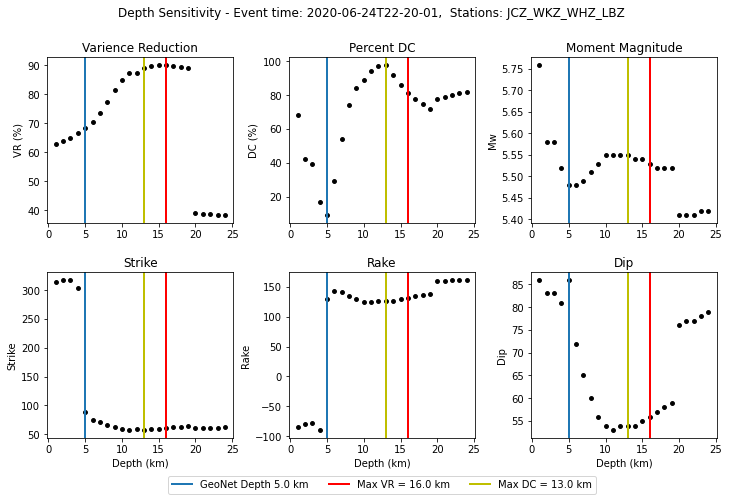

In [24]:
#Use the catelogue search to work out which event you are fitting
event = cat[0]                

# Set stations and zcor to use
best_stations = ["JCZ", "WKZ", "WHZ", "LBZ"]
#zcor_value = [64, 63, 63, 63]
zcor_value = [0,0,0,0]

# Length of trace to model. 
duration=120

#Loop through each depth to test sensitivity of parameters to depth
depthSensitivity(event, best_stations, zcor_value,duration)